<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Practice day #1: ES models </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Info</h1> 
This is first laboratory task for the course TSA.
The Lab is desinged to impove skills of tuning parameters of ES models and get experience of coding of simple Regression Models.

The Lab should take about 5-6 hours to be completed.

<h1 align="center">Important Info</h1> 
- <span style="font-size: 14pt;"> You must send your solution to the email </span> <span style="color:red; font-size: 12pt;">alexromsput@gmail.com, </span>
- The theme of your message must be <span style="color:red; font-size: 12pt;"> TSA-Erevan-2017-[Your Surname] </span>, for exmaple -- TSA-Erevan-2017-Romanenko,
- The file in attachment of the letter must be named as <span style="color:red; font-size: 12pt;"> [Surname]-[Group]-Lab1.ipnb</span>, for example -- Romanenko-Evening-Lab1.ipnb,
  
<span style="color:red; font-size: 14pt;"> DEADLINE: 7 June 2017 23:59:59 </span>


In [1]:
import pandas as pd
import numpy as np
from utils import qualityRMSE, qualityMSE, qualityMedianAE
import math
import matplotlib.pyplot as plt
%matplotlib inline
import time
import itertools
import IPython

In [2]:
def qualityMACAPE(x,y):
    # Mean average corrected absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = np.abs((2*np.abs(x-y)/(x+y+1e-8)))
    return np.nanmean(qlt)

<h1 align="center">1. Realization of ES models(50%)</h1>
Solve the task fo Prcatice Day 1 and put you solution (that means cells and outputs) below

In [3]:
###################### Init Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    adaptation_period <scalar> - adapation period for initialization

def InitExponentialSmoothing(x, Params, h=1):
#     x = np.array(x)
    T = len(x)
    alpha = Params['alpha']
    AdaptationPeriod=Params['adaptation_period']
    FORECAST = np.ones(T+h)*np.nan
    l = x[0]
    t0=0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(l):
                l=x[t]
                t0=t
            current_alpha = alpha
            if (t-t0+1)<AdaptationPeriod:
                current_alpha = 1 - (1-alpha) * (t-t0)/AdaptationPeriod
            l = l*(1-current_alpha) + current_alpha*x[t]
        FORECAST[t+h] = l
    return FORECAST

In [4]:
# AdaptiveExponentialSmoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    adaptation_period scalar> - adapation period for initialization
#    gamma<scalar in [0,1]> - parametr of cross validation

def AdaptiveExponentialSmoothing(x, Params, h=1):
#     x = np.array(x)
    T = len(x)
    
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    AdaptationPeriod=Params['adaptation_period']

    FORECAST = np.ones(T+h)*np.nan
    
    l = np.NaN
    b = np.nan
    
    t0= np.NaN
    
    e1= np.NaN
    e2= np.NaN
    Kt_1 = alpha
    K=alpha
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(l):
                l=x[t]
                b = 0
                t0=t
                e1=alpha
                e2 = 1
            elif (t-t0)>h:
                e1 = gamma*(x[t]-FORECAST[t])+(1-gamma)*e1
                e2 = gamma*np.abs(x[t]-FORECAST[t])+(1-gamma)*e2
            
            K = alpha if e2==0 else np.abs(e1/e2)
            alpha = Kt_1
            Kt_1 = K
            current_alpha = alpha
            if t-t0<AdaptationPeriod:
                current_alpha = 1 - (1-alpha) * (t-t0)/AdaptationPeriod 
            
            l_new = current_alpha * x[t] + (1-current_alpha) * (l + b)
            b = beta * (l_new - l) + (1-beta) * b
            l = l_new
        FORECAST[t+h] = (l + h*b)
    return FORECAST

In [5]:
###################### Winters Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    delts <scalar in [0,1]> - seasonality smoothing parameter
#    adaptation_period scalar> - adapation period for initialization
#    seasonality_period <scalar greater 0> - seasonality period

def WintersExponentialSmoothing(x, Params, h=1):
    T = len(x)
#     x = np.array(x)
    alpha = Params['alpha']
    delta = Params['delta']
    gamma = Params['gamma']
    
    AdaptationPeriod=Params['adaptation_period']
    p = Params['seasonality_period']
    _AdaptationPeriod = 1.0/AdaptationPeriod
    
    FORECAST = np.ones(T+h)*np.nan
    
    l= np.nan # initialize ts level 
    s= np.ones(p) * np.nan
    
    e1= np.NaN
    e2= np.NaN
    Kt_1 = alpha
    K=alpha
    for t in range(T):
        if not math.isnan(x[t]):
            if math.isnan(l):
                l=x[t] 
                t0=t
            
            if (t-t0)<h:
                e1 = gamma*(x[t]-l)+(1-gamma)*e1
                e2 = gamma*np.abs(x[t]-l)+(1-gamma)*e2
            else:
                e1 = gamma*(x[t]-FORECAST[t])+(1-gamma)*e1
                e2 = gamma*np.abs(x[t]-FORECAST[t])+(1-gamma)*e2
            if math.isnan(e2) or math.isnan(e1):
                e1=alpha
                e2 = 1
                
            t_m_p = t % p
            if math.isnan(s[t_m_p]):
                s[t_m_p]= x[t] - l 
            K = alpha if e2==0  else np.abs(e1/e2)
            alpha=Kt_1
            Kt_1=K
            current_alpha = alpha
            if t-t0<AdaptationPeriod:
                current_alpha = 1 - (1-alpha) * (t-t0)*_AdaptationPeriod 
            l = current_alpha * (x[t] - s[t_m_p]) + (1-current_alpha)*l
            s[t_m_p] = delta * (x[t] - l) + (1-delta) * s[t_m_p]
        FORECAST[t+h] = l + s[(t+h) % p]
    return FORECAST

In [6]:
# Theil Wage Model
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    beta <scalar in [0,1]> - trend smoothing parameter
#    adaptation_period scalar> - adapation period for initialization
#    gamma<scalar in [0,1]> - parametr of cross validation
#    delta<scalar in [0,1]> - seasonality smoothing parameter
#    seasonality_period <scalar greater 0> - seasonality period

def TheilWageModel(x, Params, h=1):
#     x = np.array(x)
    T = len(x)
    
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    delta = Params['delta']
    AdaptationPeriod=Params['adaptation_period']
    _AdaptationPeriod = 1.0/AdaptationPeriod
    p = Params['seasonality_period']

    FORECAST = np.ones(T+h)*np.nan
    
    l = np.NaN
    b = np.nan
    s= np.ones(p) * np.nan
    
    t0= np.NaN
    
    e1= np.NaN
    e2= np.NaN
    Kt_1 = alpha
    K=alpha
    
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(l):
                l=x[t]
                b = 0
                t0=t
            elif (t-t0)>h:
                e1 = gamma*(x[t]-FORECAST[t])+(1-gamma)*e1
                e2 = gamma*np.abs(x[t]-FORECAST[t])+(1-gamma)*e2
            if math.isnan(e2) or math.isnan(e1):
                e1=alpha
                e2 = 1
            t_m_p = t % p
            
            if math.isnan(s[t_m_p]):
                s[t_m_p]= x[t] - l 
            
            K = alpha if e2==0 else np.abs(e1/e2)
            alpha = Kt_1
            Kt_1 = K
            current_alpha = alpha
            if t-t0<AdaptationPeriod:
                current_alpha = 1 - (1-alpha) * (t-t0)*_AdaptationPeriod
            l_new = current_alpha * (x[t] - s[t_m_p]) + (1-current_alpha) * (l + b)
            b = beta * (l_new - l) + (1-beta) * b
            s[t_m_p] = delta * (x[t] - l_new) + (1-delta) * s[t_m_p]
            l = l_new
        FORECAST[t+h] = (l + h*b) + s[(t+h) % p]
    return FORECAST

<h1 align="center">2. Forecasting real TS (50%)</h1>

* I.   Download datasets (see Student ID in sheet 'Notes' <a href="https://drive.google.com/open?id=11-lzxxR0aeBmEDGEW1GiIaP4X3fyCTHxTg4b0wALpzs">here </a>) and put it into pandas Data Frame:
     - for those whose Student ID = 0 mod 3 - <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep36.csv</span> 
     - for those whose Student ID = 1 mod 3 - <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep42.csv</span> 
     - for those whose Student ID = 2 mod 3 - <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep6.csv </span>
     
<a href='https://1drv.ms/f/s!AqGgzb5T4tvShZ1-xS0s6FhP5x-05g'>link to the folder with datasets</a>

Answer questions: are there TS with seaonality in data? which is the seasonality period?
(Hint: you just need to look at aggregate data by each shop).

* II. Define the beginning of the history and the end of the history of TS (for TS_dep36.csv the beginning is 12.05.2005, the end is 13.06.2006)
    
* III. For TS_dep36.csv Find the best ES algorithm (it means ES model + its optimal parameters) for each TS by next sheme:
     
     
     - 0) Use only following ES models: IES (see seminar 2), AES (see seminar 2), Winters with additive seasonality (see Practice Day 1 task 3), Theil-Wage (see Practice Day 1 task 4).
     
     
     - 1) forecasting delay $h = 1$, loss function is MACAPE;
     
     
     - 2) For all models find optimal params of each ES models using first 75% of dates (for TS_dep36.csv from 12.05.2005 to 12.03.2006);
     
     
     - 3) forecast each TS by each ES Model with optimal params using first 90% of dates (for TS_dep36.csv from 12.05.2005 to 30.04.2006);
     - 4) find the optimal ES algorithm: just compare losses of ES models with optimal params calclated for dates that were not used for tuning parameters (for TS_dev36.csv: from 13.03.2006 to 30.04.2006).
    
    You need to remember optimal ES algorithm for each TS!
    
     - 5) Build barchar (histogram) of losses of optimal ES algorithm (were calulated at step before) for all TS (axis x - value of loss, axis y - percentage of TS that have such loss). Here you must exclude those TS which has only NaNs in period under consideration.
            
* IV. Calculate Forecast for each TS by optimal TS algorithm that you find in step 3 for all dates (for TS_dep36.csv from 12.05.2005 to 13.06.2006). 

       
     - 1) Measure accuracy (loss) of forecast for each TS using dates that were not used in step 2)-3) (for TS_dep36.csv from 12.05.2005 to 12.03.2006), here you must exclude those TS which has only NaNs in the end.
    
     - 2) Build barchar (histogram) of losses of optimal ES algorithm for all TS (axis x - value of loss, axis y - percentage of TS that has such loss), here you must exclude those TS which has only NaNs in period under consideration.

     - 3) Are barcharts calculated in step III.4) and in step IV.2) the same? If they differ than say in what manner.

In [11]:
tss = pd.read_csv('./data/TS_dep42.csv', sep=';',  decimal='.', index_col='Timestamp', parse_dates=True, dayfirst=True)
print(tss.shape)


(1135, 155)


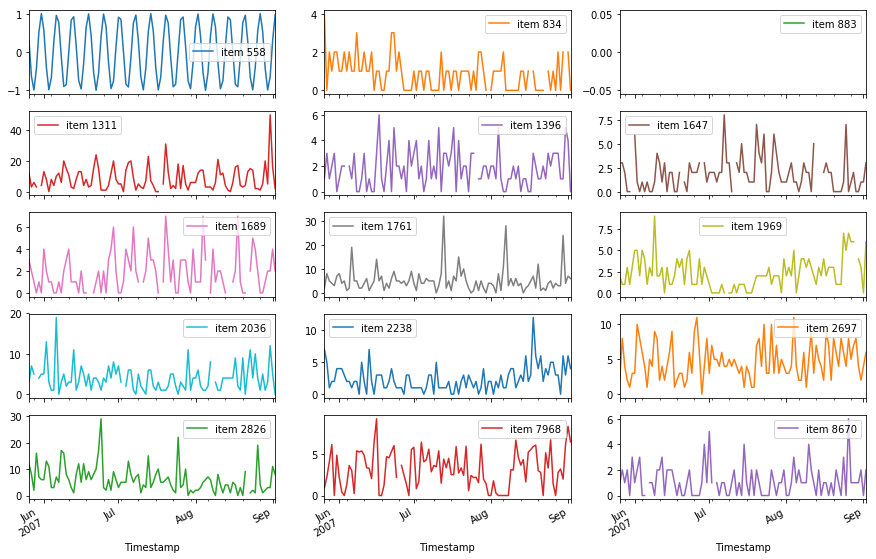

In [12]:
tss[tss.columns[:15]].iloc[600:700].plot(subplots=True, layout=(5,3), figsize=(15,10))
None

There is weekly seasonality.

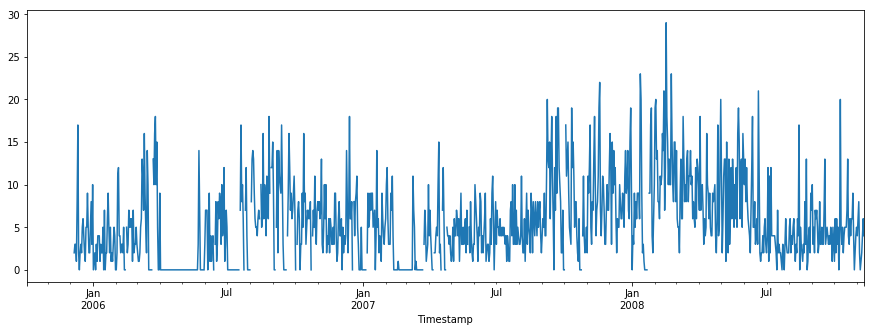

In [13]:
tss['item 2697'].iloc[:].plot(figsize=(15,5))

In [14]:
def top_params(Q):
    return np.dstack(np.unravel_index(np.argsort(Q.ravel()), Q.shape)).squeeze()

In [15]:
ALPHA = sorted([ 0.05, 0.12, 0.26, 0.40, 0.65, 0.73, 0.87, 0.95, ] )
BETA =  sorted([ 0.05, 0.10, 0.16, 0.30, 0.47, 0.67, 0.84, 0.95, ] )
DELTA = sorted([ 0.10, 0.22, 0.30, 0.47, 0.61, 0.73, 0.86, 0.94, ] )
A = len(ALPHA) * len(BETA) * len(DELTA)
print(A)

512


In [16]:
def get_result(ts):
    # ts_valid1_point = ts.dropna().index[int(ts.dropna().shape[0]*0.75)]
    # ts_valid2_point = ts.dropna().index[int(ts.dropna().shape[0]*0.90)]
    ts_valid1_point = ts.dropna().index[int(ts.dropna().shape[0]*0.75)]
    ts_valid2_point = ts.dropna().index[int(ts.dropna().shape[0]*0.90)]
    ts.index[0], ts_valid1_point, ts_valid2_point, ts.index[-1]

    i = 0
    param = {'alpha':0, 'beta':0, 'gamma':0.05, 'delta':0,
                                           'adaptation_period':10, 'seasonality_period':7}
    Quality = np.ones((4, len(ALPHA),len(BETA),len(DELTA))) * np.nan
    Quality = {}
    Quality["InitExponentialSmoothing"] = np.ones((len(ALPHA)))*np.nan
    Quality['AdaptiveExponentialSmoothing'] = np.ones((len(ALPHA), len(BETA)))*np.nan
    Quality['WintersExponentialSmoothing'] = np.ones((len(ALPHA),len(DELTA)))*np.nan
    Quality['TheilWageModel'] = np.ones((len(ALPHA),len(BETA),len(DELTA)))*np.nan



    ts_valid1_array = np.array(ts.loc[:ts_valid1_point])
    for i_alpha, alpha in enumerate(ALPHA):
        param['alpha'] = alpha
        for i_delta, delta in enumerate(DELTA):
            param['delta'] = delta
            forecast = WintersExponentialSmoothing(ts_valid1_array, param)
            Quality['WintersExponentialSmoothing'][i_alpha, i_delta] = qualityMACAPE(ts_valid1_array, forecast[:-1])
            for i_beta, beta in enumerate(BETA):
                param['beta'] = beta
                i = i + 1
                forecast = TheilWageModel(ts_valid1_array, param)
                Quality['TheilWageModel'][i_alpha, i_beta, i_delta] = qualityMACAPE(ts_valid1_array, forecast[:-1])
        for i_beta, beta in enumerate(BETA):
            param['beta'] = beta
            forecast = AdaptiveExponentialSmoothing(ts_valid1_array,param)
            Quality['AdaptiveExponentialSmoothing'][i_alpha, i_beta] = qualityMACAPE(ts_valid1_array, forecast[:-1])
        forecast = InitExponentialSmoothing(ts_valid1_array,param)
        Quality['InitExponentialSmoothing'][i_alpha] = qualityMACAPE(ts_valid1_array, forecast[:-1])
    

    Quality['InitExponentialSmoothing'] = {'params':top_params(Quality['InitExponentialSmoothing'])}
    Quality['AdaptiveExponentialSmoothing'] = {'params':top_params(Quality['AdaptiveExponentialSmoothing'])}
    Quality['WintersExponentialSmoothing'] = {'params':top_params(Quality['WintersExponentialSmoothing'])}
    Quality['TheilWageModel'] = {'params':top_params(Quality['TheilWageModel'])}

    param = {'alpha':0, 'beta':0, 'gamma':0.05, 'delta':0,
                                           'adaptation_period':10, 'seasonality_period':7}

    # Init Exponential Smoothing
    param_list = Quality['InitExponentialSmoothing']['params'][0]
    param['alpha'] = ALPHA[param_list]
    forecast = InitExponentialSmoothing(ts[:ts_valid2_point], param)[:-1]
    Quality['InitExponentialSmoothing']['loss'] = qualityMACAPE(pd.Series(forecast, index=ts.loc[:ts_valid2_point].index)[ts_valid1_point:ts_valid2_point], 
                  ts[ts_valid1_point:ts_valid2_point])


    # AdaptiveExponentialSmoothing
    param_list = Quality['AdaptiveExponentialSmoothing']['params'][0]
    param['alpha'] = ALPHA[param_list[0]]
    param['beta'] = BETA[param_list[1]]
    forecast = AdaptiveExponentialSmoothing(ts[:ts_valid2_point], param)[:-1]
    Quality['AdaptiveExponentialSmoothing']['loss'] = qualityMACAPE(pd.Series(forecast, index=ts.loc[:ts_valid2_point].index)[ts_valid1_point:ts_valid2_point], 
                  ts[ts_valid1_point:ts_valid2_point])


    # Winters model
    param_list = Quality['WintersExponentialSmoothing']['params'][0]
    param['alpha'] = ALPHA[param_list[0]]
    param['delta'] = DELTA[param_list[1]]
    forecast = WintersExponentialSmoothing(ts[:ts_valid2_point], param)[:-1]
    Quality['WintersExponentialSmoothing']['loss'] = qualityMACAPE(pd.Series(forecast, index=ts.loc[:ts_valid2_point].index)[ts_valid1_point:ts_valid2_point], 
                  ts[ts_valid1_point:ts_valid2_point])


    # Theil Wage Model
    param_list = Quality['TheilWageModel']['params'][0]
    param['alpha'] = ALPHA[param_list[0]]
    param['beta'] = BETA[param_list[1]]
    param['delta'] = DELTA[param_list[2]]
    forecast = TheilWageModel(ts[:ts_valid2_point], param)[:-1]
    Quality['TheilWageModel']['loss'] = qualityMACAPE(pd.Series(forecast, index=ts.loc[:ts_valid2_point].index)[ts_valid1_point:ts_valid2_point], 
                  ts[ts_valid1_point:ts_valid2_point])



    best_result = {'algorithm':None, 'loss':np.inf, }
    for algorithm, result in Quality.items():
        if best_result['loss'] > result['loss']:
            best_result['loss'] = result['loss']
            best_result['param'] = result['params'][0]
            best_result['algorithm'] = algorithm

    param = {'alpha':0, 'beta':0, 'gamma':0.05, 'delta':0,
                                           'adaptation_period':10, 'seasonality_period':7}
    # Init Exponential Smoothing
    if best_result['algorithm'] == 'InitExponentialSmoothing':
        param_list = best_result['param']
        param['alpha'] = ALPHA[param_list]
        del param['beta'],param['gamma'], param['delta'],  param['seasonality_period']
        forecast = InitExponentialSmoothing(ts[:], param)[:-1]
        best_result['loss test'] = qualityMACAPE(pd.Series(forecast, index=ts.index)[ts_valid2_point:], 
                      ts[ts_valid2_point:])
        best_result['loss'] = qualityMACAPE(pd.Series(forecast, index=ts.index), ts)
        best_result['param'] = param

    elif best_result['algorithm'] == 'AdaptiveExponentialSmoothing':
        # AdaptiveExponentialSmoothing
        param_list = Quality['AdaptiveExponentialSmoothing']['params'][0]
        param['alpha'] = ALPHA[param_list[0]]
        param['beta'] = BETA[param_list[1]]
        del param['delta'],  param['seasonality_period']
        
        forecast = AdaptiveExponentialSmoothing(ts[:], param)[:-1]
        best_result['loss test'] = qualityMACAPE(pd.Series(forecast, index=ts.index)[ts_valid2_point:], 
                      ts[ts_valid2_point:])
        best_result['loss'] = qualityMACAPE(pd.Series(forecast, index=ts.index), ts)
        best_result['param'] = param
        
    elif best_result['algorithm'] == 'WintersExponentialSmoothing':
        # Winters model
        param_list = Quality['WintersExponentialSmoothing']['params'][0]
        param['alpha'] = ALPHA[param_list[0]]
        param['delta'] = DELTA[param_list[1]]
        del param['beta']
        
        forecast = WintersExponentialSmoothing(ts[:], param)[:-1]
        best_result['loss test'] = qualityMACAPE(pd.Series(forecast, index=ts.index)[ts_valid2_point:], 
                      ts[ts_valid2_point:])
        best_result['loss'] = qualityMACAPE(pd.Series(forecast, index=ts.index), ts)
        best_result['param'] = param
        
    elif best_result['algorithm'] == 'TheilWageModel':
        # Theil Wage Model
        param_list = Quality['TheilWageModel']['params'][0]
        param['alpha'] = ALPHA[param_list[0]]
        param['beta'] = BETA[param_list[1]]
        param['delta'] = DELTA[param_list[2]]
        forecast = TheilWageModel(ts[:], param)[:-1]
        best_result['loss test'] = qualityMACAPE(pd.Series(forecast, index=ts.index)[ts_valid2_point:], 
                      ts[ts_valid2_point:])
        best_result['loss'] = qualityMACAPE(pd.Series(forecast, index=ts.index), ts)
        best_result['param'] = param
        
    else:
        raise Exception()
    return best_result

In [43]:
ts_results = []
not_float_tss = []
start = time.time()
for i,ts_name in enumerate(tss.columns):
    
    ts = tss[ts_name]
    if ts.dtype != float:
        not_float_tss.append(ts_name)
        continue
    
    result = get_result(ts)
    ts_results.append({'name':ts_name, 'result':result})
    IPython.display.clear_output(wait=True)
    print('Completed %0.1f%% (time: %0.1fs)' % ((i+1)*100.0/tss.shape[1], time.time()-start ))

Completed 99.4% (time: 416.6s)


In [69]:
import json

In [75]:
with open('ts_results.json', 'r') as outfile:
    ts_results = json.load(outfile)

In [68]:
with open('ts_results.json', 'w') as outfile:
    json.dump(ts_results, outfile)

In [49]:
loss = []
loss_test = []
for result in ts_results:
    loss.append(result['result']['loss'])
    loss_test.append(result['result']['loss test'])

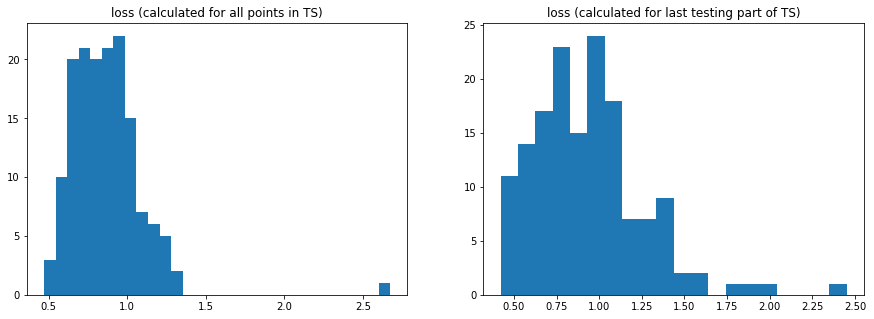

In [64]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(loss, bins=30)
plt.title('loss (calculated for all points in TS)')
plt.subplot(122)
plt.hist(loss_test, bins=20)
plt.title('loss (calculated for last testing part of TS)')
None